In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
path = '/content/drive/MyDrive/Research/AAAI/dataset1/second_layer_without_entropy/'

In [86]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Generate dataset

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


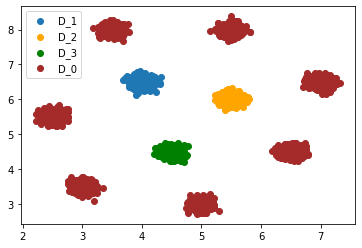

In [87]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)
x = np.zeros((5000,2))
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))
color = ['#1F77B4','orange', 'g','brown']
name = [1,2,3,0]
for i in range(10):
  if i==3:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3],label="D_"+str(name[i]))
  elif i>=4:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[i],label="D_"+str(name[i]))
plt.legend()

In [88]:
x[idx[0]][0], x[idx[5]][5] 

(array([4.04729858, 6.43185741]), array([3.4612816 , 8.00144771]))

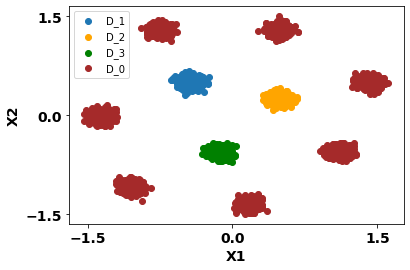

In [89]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

color = ['#1F77B4','orange', 'g','brown']
for i in range(10):
  if i==3:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3],label="D_"+str(name[i]))
  elif i>=4:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[3])
  else:
    plt.scatter(x[idx[i],0],x[idx[i],1],c=color[i],label="D_"+str(name[i]))
plt.legend()
plt.xticks([-1.5, 0, 1.5], fontsize=14, fontweight = 'bold')
plt.yticks([ -1.5, 0, 1.5], fontsize=14, fontweight = 'bold')
plt.xlabel("X1", fontsize=14, fontweight = 'bold')
plt.ylabel("X2" , fontsize=14, fontweight = 'bold')
plt.savefig(path+"ds1_data.png", bbox_inches="tight")
plt.savefig(path+"ds1_data.pdf", bbox_inches="tight")

In [90]:
print(np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True))
print(np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True))

[[-8.79376908e-16 -1.21527231e-15]] [[-0.01528434  0.02065383]]
[[1. 1.]] [[0.86429775 0.8750994 ]]


In [91]:
foreground_classes = {'class_1','class_2', 'class_3'}

background_classes = {'class_0'}

In [92]:
desired_num = 3000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(a)
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [93]:
len(mosaic_list_of_images), mosaic_list_of_images[0]

(3000, array([[-1.07390719, -1.04959598],
        [-1.30547943, -0.083791  ],
        [ 1.10227457, -0.5565904 ],
        [ 1.44996512,  0.52630897],
        [ 0.18635473, -1.38666417],
        [-0.36332091,  0.57254869],
        [-0.78873321,  1.29405413],
        [ 0.18456746, -1.32037523],
        [ 0.12342288, -1.3350683 ]]))

In [94]:
mosaic_list_of_images_reshaped = np.reshape(mosaic_list_of_images, (3000,9,2))
mean_train = np.mean(mosaic_list_of_images_reshaped[0:1500], axis=0, keepdims= True)
print(mean_train.shape, mean_train)
std_train = np.std(mosaic_list_of_images_reshaped[0:1500], axis=0, keepdims= True)
print(std_train.shape, std_train)

(1, 9, 2) [[[ 0.00060276 -0.00499119]
  [-0.02448583 -0.00671386]
  [-0.02890783  0.05365497]
  [-0.03193243  0.00852372]
  [-0.02192776  0.02130545]
  [-0.01590578  0.02510277]
  [-0.01647343  0.02218796]
  [-0.0126789   0.01008437]
  [-0.03680346  0.02897708]]]
(1, 9, 2) [[[0.95610652 0.9444985 ]
  [0.95628012 0.93903267]
  [0.95808133 0.95049526]
  [0.95438142 0.94703127]
  [0.95325373 0.96368369]
  [0.94227026 0.96111035]
  [0.95832615 0.95265297]
  [0.94996601 0.9595237 ]
  [0.94998439 0.95897534]]]


In [95]:
mosaic_list_of_images = ( mosaic_list_of_images_reshaped - mean_train ) / std_train

In [96]:
print(np.mean(mosaic_list_of_images[0:1500], axis=0, keepdims= True))

print(np.std(mosaic_list_of_images[0:1500], axis=0, keepdims= True))

[[[ 3.50830476e-17 -8.88178420e-19]
  [ 5.89158352e-17 -4.07683147e-17]
  [-1.13316763e-16  1.73046762e-16]
  [ 1.33226763e-18  2.22044605e-17]
  [ 4.14483263e-18  2.84217094e-17]
  [-6.24315414e-17  6.32827124e-18]
  [ 3.21224528e-17 -1.64266748e-17]
  [ 5.62512999e-18 -5.34387349e-17]
  [ 6.76495896e-17  2.65059965e-17]]]
[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]


In [97]:
print(np.mean(mosaic_list_of_images[1500:3000], axis=0, keepdims= True))

print(np.std(mosaic_list_of_images[1500:3000], axis=0, keepdims= True))

[[[-0.00277783  0.01848762]
  [-0.00602214 -0.00967387]
  [ 0.01110467 -0.05209602]
  [ 0.03955482  0.03879225]
  [ 0.03470004 -0.00440774]
  [ 0.04310378 -0.02717248]
  [-0.03442996 -0.05405024]
  [-0.00200211  0.00378318]
  [ 0.01859386 -0.03283624]]]
[[[1.00221356 1.00442826]
  [1.01410373 0.99826801]
  [0.9833115  0.99339062]
  [1.01845513 0.97591529]
  [0.99070455 1.00506142]
  [1.01800042 0.98373753]
  [0.98899577 1.01090329]
  [1.01235138 0.99181268]
  [0.9970391  1.00580643]]]


In [98]:
mosaic_list_of_images.shape

(3000, 9, 2)

# load mosaic data

In [99]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [100]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:1500], mosaic_label[0:1500] , fore_idx[0:1500])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [101]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[1500:3000], mosaic_label[1500:3000] , fore_idx[1500:3000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

# models

In [102]:
class Focus_deep(nn.Module):
    '''
       deep focus network averaged at zeroth layer
       input : elemental data
    '''
    def __init__(self,inputs,output,K,d):
        super(Focus_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.K = K
        self.d  = d
        self.linear1 = nn.Linear(self.inputs,50, bias=False)  #,self.output)
        self.linear2 = nn.Linear(50,50 , bias=False)
        self.linear3 = nn.Linear(50,self.output, bias=False) 

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        
    def forward(self,z):
        batch = z.shape[0]
        x = torch.zeros([batch,self.K],dtype=torch.float64)
        y = torch.zeros([batch,50], dtype=torch.float64)   # number of features of output
        features = torch.zeros([batch,self.K,50],dtype=torch.float64)
        x,y = x.to("cuda"),y.to("cuda")
        features = features.to("cuda")
        for i in range(self.K):
            alp,ftrs = self.helper(z[:,i] )  # self.d*i:self.d*i+self.d
            x[:,i] = alp[:,0]
            features[:,i]  = ftrs 
        x = F.softmax(x,dim=1)   # alphas
        for i in range(self.K):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],features[:,i])  # self.d*i:self.d*i+self.d
        return y , x 
    def helper(self,x):
      x = self.linear1(x)
      x = F.relu(x) 
      x = self.linear2(x)
      x1 = F.tanh(x)
      x = F.relu(x)
      x = self.linear3(x)
      #print(x1.shape)
      return x,x1

In [103]:
class Classification_deep(nn.Module):
    '''
       input : elemental data
       deep classification module data averaged at zeroth layer
    '''
    def __init__(self,inputs,output):
        super(Classification_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.linear1 = nn.Linear(self.inputs,50)
        #self.linear2 = nn.Linear(6,12)
        self.linear2 = nn.Linear(50,self.output)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
      x = F.relu(self.linear1(x))
      #x = F.relu(self.linear2(x))
      x = self.linear2(x)
      return x    

In [104]:
torch.manual_seed(12)
focus_net = Focus_deep(2,1,9,2).double()
focus_net = focus_net.to("cuda")

In [105]:
focus_net.linear2.weight.shape,focus_net.linear3.weight.shape

(torch.Size([50, 50]), torch.Size([1, 50]))

In [106]:
focus_net.linear2.weight.data[25:,:] = focus_net.linear2.weight.data[:25,:] #torch.nn.Parameter(torch.tensor([last_layer]) )
(focus_net.linear2.weight[:25,:]== focus_net.linear2.weight[25:,:] )

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')

In [107]:
focus_net.linear3.weight.data[:,25:] = -focus_net.linear3.weight.data[:,:25] #torch.nn.Parameter(torch.tensor([last_layer]) )
focus_net.linear3.weight

Parameter containing:
tensor([[ 0.0303,  0.0454, -0.0407, -0.2755, -0.1269,  0.1393, -0.0702, -0.0347,
         -0.5333, -0.1169, -0.0596,  0.1067, -0.1334,  0.1237, -0.0199, -0.0470,
         -0.0732,  0.0081, -0.0264,  0.0922,  0.3229,  0.0115,  0.0914, -0.1149,
         -0.0232, -0.0303, -0.0454,  0.0407,  0.2755,  0.1269, -0.1393,  0.0702,
          0.0347,  0.5333,  0.1169,  0.0596, -0.1067,  0.1334, -0.1237,  0.0199,
          0.0470,  0.0732, -0.0081,  0.0264, -0.0922, -0.3229, -0.0115, -0.0914,
          0.1149,  0.0232]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)

In [108]:
ex,_ = focus_net.helper( torch.randn((5,2,2)).double().to("cuda") )
print(ex)

tensor([[[ 6.9389e-18],
         [-6.9389e-18]],

        [[-3.4694e-18],
         [-8.6736e-19]],

        [[-3.4694e-18],
         [ 0.0000e+00]],

        [[-6.9389e-18],
         [ 3.4694e-18]],

        [[ 1.0408e-17],
         [-3.4694e-18]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsafeViewBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [109]:
def calculate_attn_loss(dataloader,what,where,criter):
  what.eval()
  where.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      avg,alpha = where(inputs)
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())
      loss = criter(outputs, labels)
      r_loss += loss.item()
  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,analysis

In [110]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

# training

In [111]:
number_runs = 20
FTPT_analysis = pd.DataFrame(columns = ["FTPT","FFPT", "FTPF","FFPF"])
full_analysis= []
for n in range(number_runs):
  print("--"*40)
  
  # instantiate focus and classification Model
  torch.manual_seed(n)
  where = Focus_deep(2,1,9,2).double()
  where.linear2.weight.data[25:,:] = where.linear2.weight.data[:25,:]
  where.linear3.weight.data[:,25:] = -where.linear3.weight.data[:,:25]
  where = where.double().to("cuda")
  ex,_ = where.helper( torch.randn((5,2,2)).double().to("cuda"))
  print(ex)

  torch.manual_seed(n)
  what = Classification_deep(50,3).double()
  where = where.to("cuda")
  what = what.to("cuda")



  # instantiate optimizer
  optimizer_where = optim.Adam(where.parameters(),lr =0.001)#,momentum=0.9)
  optimizer_what = optim.Adam(what.parameters(), lr=0.001)#,momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  acti = []
  analysis_data = []
  loss_curi = []
  epochs = 2000


  # calculate zeroth epoch loss and FTPT values
  running_loss,anlys_data = calculate_attn_loss(train_loader,what,where,criterion)
  loss_curi.append(running_loss)
  analysis_data.append(anlys_data)

  print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 

  # training starts 
  for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []
    running_loss = 0.0
    what.train()
    where.train()
    for i, data in enumerate(train_loader, 0):
      # get the inputs
      inputs, labels,_ = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")

      # zero the parameter gradients
      optimizer_where.zero_grad()
      optimizer_what.zero_grad()
      
      # forward + backward + optimize
      avg, alpha = where(inputs)
      outputs = what(avg)
      loss = criterion(outputs, labels)

      # print statistics
      running_loss += loss.item()
      loss.backward()
      optimizer_where.step()
      optimizer_what.step()

    running_loss,anls_data = calculate_attn_loss(train_loader,what,where,criterion)
    analysis_data.append(anls_data)
    if(epoch % 50==0):
      print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
    loss_curi.append(running_loss)   #loss per epoch
    if running_loss<=0.01:
      break
  print('Finished Training run ' +str(n)+' at epoch: ',epoch)
  analysis_data = np.array(analysis_data)
  FTPT_analysis.loc[n] = analysis_data[-1,:4]/15
  full_analysis.append((epoch, analysis_data))
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels,_ = data
      images = images.double()
      images, labels = images.to("cuda"), labels.to("cuda")
      avg, alpha = where(images)
      outputs  = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 1500 test images: %d %%' % (  100 * correct / total))
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


--------------------------------------------------------------------------------
tensor([[[ 8.6736e-19],
         [-1.0408e-17]],

        [[-8.4568e-18],
         [ 0.0000e+00]],

        [[-8.6736e-18],
         [ 6.0173e-18]],

        [[-6.9389e-18],
         [-6.9389e-18]],

        [[ 8.6736e-19],
         [-2.0817e-17]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsafeViewBackward>)
epoch: [0 ] loss: 1.310
epoch: [1] loss: 1.299
Finished Training run 0 at epoch:  21
Accuracy of the network on the 1500 test images: 100 %
--------------------------------------------------------------------------------
tensor([[[-6.9389e-18],
         [ 9.3648e-18]],

        [[-5.2313e-18],
         [-6.9389e-18]],

        [[ 2.7756e-17],
         [ 6.9389e-18]],

        [[ 3.4694e-18],
         [ 7.5894e-19]],

        [[ 0.0000e+00],
         [-1.7347e-18]]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsafeViewBackward>)
epoch: [0 ] loss: 1.325
epoch: [1] loss: 1.310
F

In [112]:
print(np.mean(np.array(FTPT_analysis),axis=0))

[100.   0.   0.   0.]


In [113]:
FTPT_analysis

,FTPT,FFPT,FTPF,FFPF
0,100.0,0.0,0.0,0.0
1,100.0,0.0,0.0,0.0
2,100.0,0.0,0.0,0.0
3,100.0,0.0,0.0,0.0
4,100.0,0.0,0.0,0.0
5,100.0,0.0,0.0,0.0
6,100.0,0.0,0.0,0.0
7,100.0,0.0,0.0,0.0
8,100.0,0.0,0.0,0.0
9,100.0,0.0,0.0,0.0


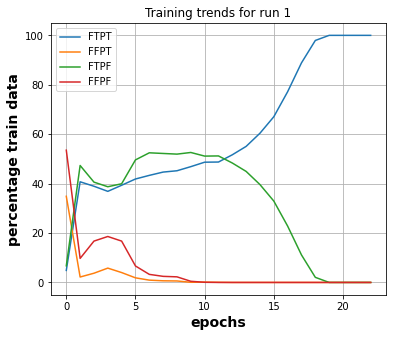

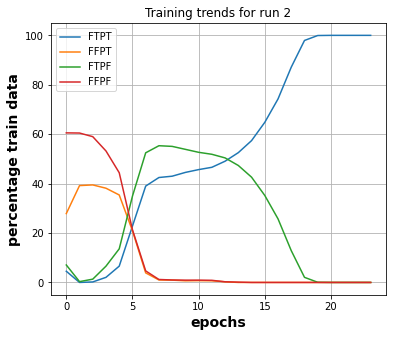

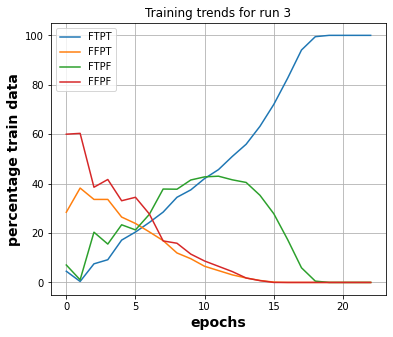

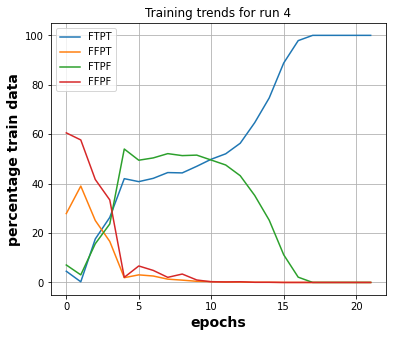

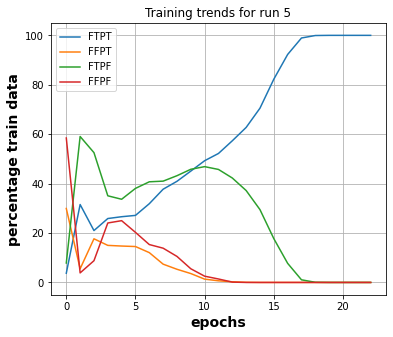

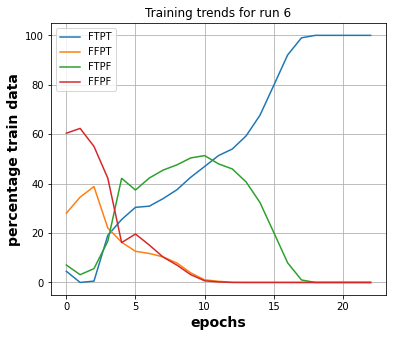

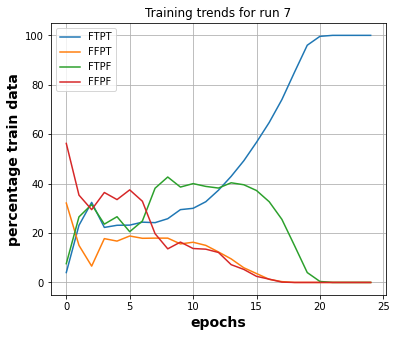

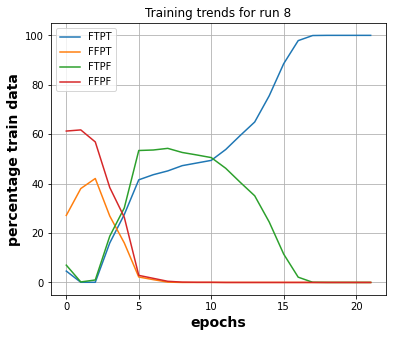

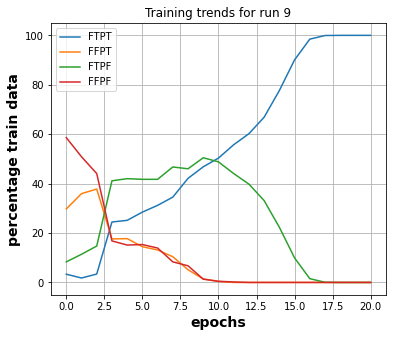

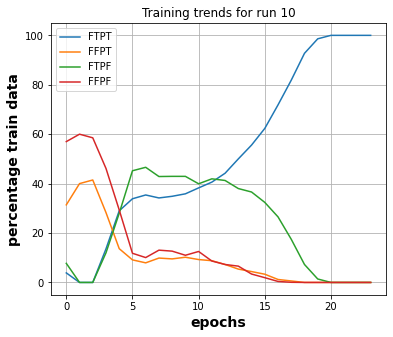

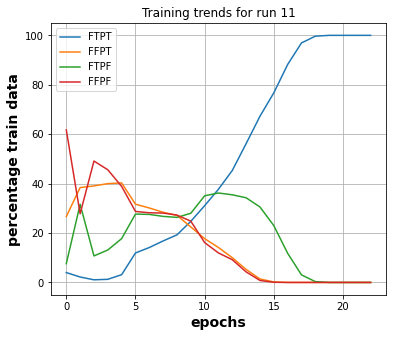

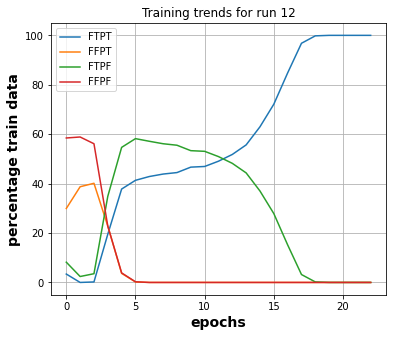

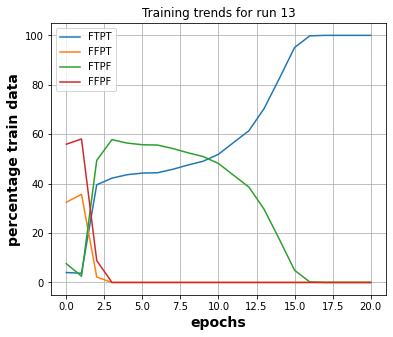

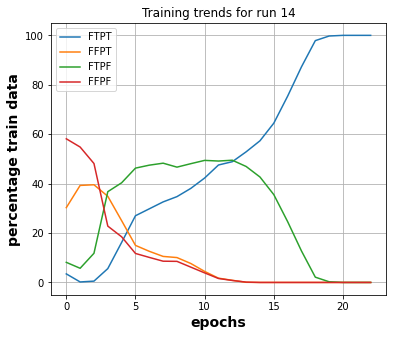

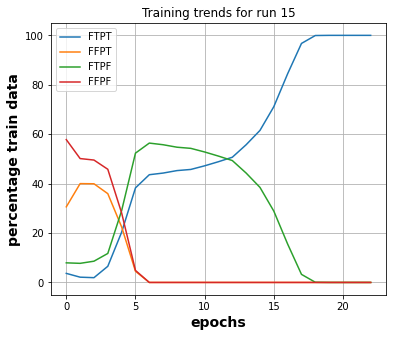

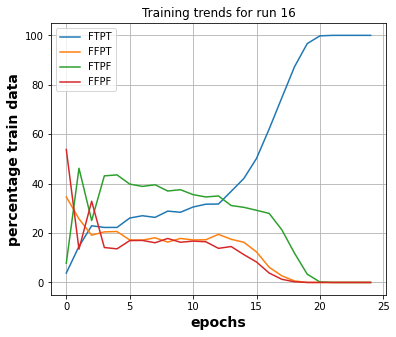

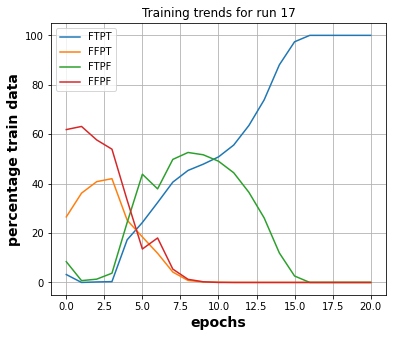

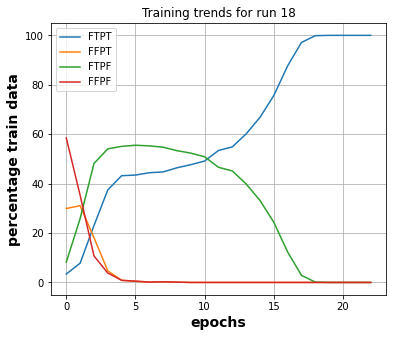

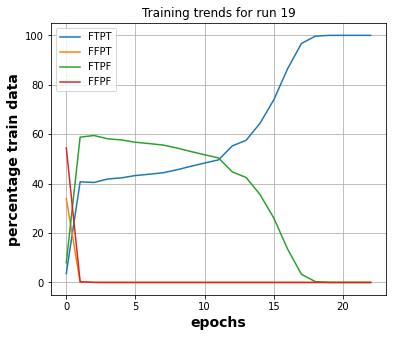

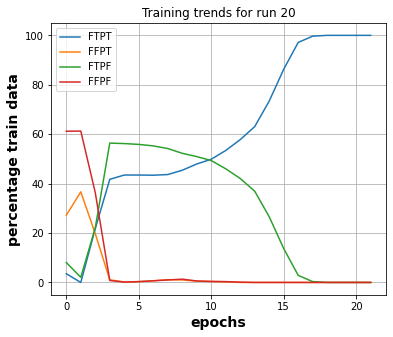

In [114]:
cnt=1
for epoch, analysis_data in full_analysis:
  analysis_data = np.array(analysis_data)
  # print("="*20+"run ",cnt,"="*20)
  
  plt.figure(figsize=(6,5))
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,0]/15,label="FTPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,1]/15,label="FFPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,2]/15,label="FTPF")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,3]/15,label="FFPF")

  plt.title("Training trends for run "+str(cnt))
  plt.grid()
  # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend()
  plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
  plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
  plt.savefig(path + "run"+str(cnt)+".png",bbox_inches="tight")
  plt.savefig(path + "run"+str(cnt)+".pdf",bbox_inches="tight")
  cnt+=1

In [115]:
FTPT_analysis.to_csv(path+"synthetic_zeroth.csv",index=False)